# Assignment - 2: Data Representation and Point Cloud Operations

Team Name: Family

Roll number: 2019102014, 2019102017

# Instructions

- Code must be written in Python in Jupyter Notebooks. We highly recommend using anaconda distribution or at the minimum, virtual environments for this assignment.
- Save all your results in ```results/<question_number>/<sub_topic_number>/```
- The **References** section provides you with important resources to solve the assignment.
- Make sure your code is modular since you may need to reuse parts for future assignments.
- Answer the descriptive questions in your own words with context & clarity. Do not copy answers from online resources or lecture notes.
- The **deadline** for this assignment is on 26/09/2021 at 11:55pm. Please note that there will be no extensions.
- Plagiarism is **strictly prohibited**.

# Submission Instructions

1. Make sure your code runs without any errors after reinitializing the kernel and removing all saved variables.
2. After completing your code and saving your results, zip the folder with name as ``Team_<team_name>_MR2021_Assignment_<assignment_number>.zip``

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import struct
import open3d
import cv2
import io
import copy

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Introduction to types of Transformations and Homogeneous coordinates

In robotics applications, it is inevitable to keep track of the frames of multiple objects/worlds. These frames can be transformations from one coordinate frame to the other. **Homogeneous coordinates** help in keeping track of various coordinate frames and allow performing composition of various transforms. We will first try to understand between types of transformations and their invariant properties.
1. What is the difference between Affine, Similarity, and Euclidean transform? What are the invariant properities of each type of transform?
2. Watch this [video](https://www.youtube.com/watch?v=PvEl63t-opM) to briefly understand homogeneous coordinates. What are points at infinity? What type of transformation can you apply to transform a point from infinity to a point that is not at infinity? 
3. Using homogeneous coordinates we can represent different types of transformation as point transforms vs. frame transforms. Concatenation of transforms (whether you post multiply transformation matrices or pre-multiply transformation matrices) depends on the problem and how you are viewing it. Try to understand the difference between frame vs. point transformations from this [video](https://youtu.be/Za7Sdegf8m8?t=1834). Let's assume that our camera and world frames are coinciding with each other. We need to estimate the camera to world **frame** transformation matrix after applying the transformations defined below in terms of $T_i$.We apply **frame** transform to move the camera in the world in the following order:
    1. $T_1$ from the camera coordinate frame.
    2. $T_2$ from the world coordinate frame.
    3. $T_3$ from the world coordinate frame.
    4. $T_4$ from the camera coordinate frame.
    5. $T_5$ from the camera coordinate frame.


<b>1.</b><br>
   <b> 1.1.</b> Euclidean transform preserves angle and lengths, similarity transform preserves ratios of lengths, areas, and angles while affine transform preserves parallelism.<br>
   <b> 1.2.</b>In terms of degrees of freedom, Affine transform has 6 DOF, Similarity transform has 4 DOF while euclidean transform has only 3 DOF.<br>
<b>2.</b> Point where parallel lines appear to converge is to be taken as point at infinity(also called vanishing point). Perspective transform can be used to transform a point at infinity to a point at finite distance. This can be shown with the following example: 
$$\begin{bmatrix} 0 & 0 & 1 & 0\end{bmatrix} \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & x \end{bmatrix} = \begin{bmatrix} 0 & 0 & 1/x & 1\end{bmatrix}$$<br>
Now the point at infinity is projected to a final distance of 1/x units <br>
<b>3.</b> It is given that the camera and world frame are coinciding with each other due to which there's no initial transform. Now based on the coordinate frame the transformations are applied on, we post or pre multiply the transformation matrix.
<center>T = $[T_3T_2T_1T_4T_5]^{-1}$ = $T_5^{-1}T_4^{-1}T_1^{-1}T_2^{-1}T_3^{-1}$</center>
NOTE: The inverse is needed as we need to estimate camera to world frame.   

# Visualise the Data

Point clouds are a collection of points that represent a 3D shape or feature. Each point has its own set of X, Y and Z coordinates and in some cases additional attributes. A popular way to obtain this is by photogrammetry, though here we will use LiDAR data.

LiDAR is a remote sensing process which collects measurements used to create 3D models and maps of objects and environments. Using ultraviolet, visible, or near-infrared light, LiDAR gauges spatial relationships and shapes by measuring the time it takes for signals to bounce off objects and return to the scanner.

1. Download the data from [here](https://iiitaphyd-my.sharepoint.com/:f:/g/personal/venkata_surya_students_iiit_ac_in/EnYAMaTVIhJItzKYqtahE30BRKB6p6UfHN3TyJzvo6Mw0g?e=PegWds). It contains the LIDAR sensor output and odometry information per frame.

    The .bin files contain the 3D point cloud captured by the LIDAR in this format - x, y, z, and reflectance. 

    The odometry information is given in the `odometry.txt` file, which is a 12 element vector. Reshape each of the first 77 rows to a 3x4 matrix to obtain the pose.
    

2. Obtain the point cloud from this and visualise for 1-2 frames.

# Answers:

### Part 1

In [2]:
lines = []
with io.open("data/odometry.txt", mode="r", encoding="utf-8") as file:
    for row in file:
        l = row.split()
        lines.append(l)
# print(lines)

In [3]:
#Convert to float
val = np.array(lines).astype('float')
print(val)
print(val.shape)

[[ 1.000000e+00  9.043683e-12  2.326809e-11 ...  2.392370e-10
   9.999999e-01 -2.220446e-16]
 [ 9.990498e-01 -1.649780e-03  4.355194e-02 ...  2.576529e-03
   9.990480e-01  1.000725e+00]
 [ 9.960495e-01 -5.367949e-03  8.863831e-02 ...  7.485875e-03
   9.960394e-01  1.995659e+00]
 ...
 [ 8.521727e-01 -2.191437e-02  5.228017e-01 ...  6.730095e-02
   8.512152e-01 -1.048145e+03]
 [ 8.510645e-01 -2.217815e-02  5.245927e-01 ...  6.729994e-02
   8.501262e-01 -1.046739e+03]
 [ 8.499437e-01 -2.495543e-02  5.262823e-01 ...  6.530726e-02
   8.492505e-01 -1.045291e+03]]
(1101, 12)


In [4]:
#Obtaining the first 77 rows
odometry = val[:77, :]
print(odometry.shape)
# print(odometry)

(77, 12)


In [5]:
# Reshape into 3x4 matrix
Pose = np.zeros((77,3,4))
for i in range(odometry.shape[0]):
    p = np.reshape(odometry[i], (3, 4))
    Pose[i] = p
# print(Pose[2])

### Part 2

In [6]:
# Read LiDAR sensor data and convert to PCD format for easier visualisation
def BinToPCD(data):
    PCD_point=[]
    with open(data,"rb") as file:
        val = file.read(16)
        while val:
            x,y,z,reflectance = struct.unpack("ffff",val)
            PCD_point.append([x,y,z])
            val = file.read(16)
    pcd = open3d.geometry.PointCloud()
    pcd.points = open3d.utility.Vector3dVector(np.array(PCD_point))
    return pcd

In [7]:

#To combine all and check
z = []
for j in range(1,9):
    for i in range(10):
        if(j==8 and i==7):
            break;
        path = "data/LiDAR/0000"+str(j)+str(i)+".bin"
        z1 = BinToPCD(path)
        z.append(z1)
# # print(z)
#To visualise just 1-2 frames
z1 = BinToPCD("data/LiDAR/000010.bin")
z2 = BinToPCD("data/LiDAR/000039.bin")
# z3 = BinToPCD("data/LiDAR/000085.bin")
# z4 = BinToPCD("data/LiDAR/000077.bin")

In [8]:
# len(z)

In [9]:
open3d.visualization.draw_geometries([z1])
# open3d.visualization.draw_geometries(z)

In [10]:
open3d.visualization.draw_geometries([z2])

# Transform 

The point cloud obtained is with respect to the LiDAR frame. The poses however, are in the camera frame. If we want to combine the point clouds from various frames, we need to bring them to the camera frame. 

1. Refer to the image below and apply the required transformation to the point cloud. 

2. Then, register all point clouds into a common reference frame and visualise it (Open3D). It is helpful to use homogeneous coordinates to keep track of the different frames.

3. Write a function to transform the registered point cloud from the world to the $i^{th}$ camera frame, wherein $i$ is the input to the function.

4. \[Bonus\] Move around in the registered point cloud using arrow keys like you would do in a game. For this you will have to regularly transform the entire registered world to your current camera frame and visualize repeatedly. You may choose to avoid visualizing points that are behind the camera in this case as they are not visible from the scene. You may also visualize points at a max depth to make the process easier.

![](./img/transform.png)

In [11]:
def XYZtoRotationMatrix(a,b,g):
    cosA = math.cos(a)
    cosB = math.cos(b)
    cosG = math.cos(g)
    sinA = math.sin(a)
    sinB = math.sin(b)
    sinG = math.sin(g)
    
    rotationMatrix = [[cosB * cosG, -cosB * sinG, sinB],
                      [((sinA * sinB * cosG) + (cosA * sinG)) , ((-sinA * sinB * sinG) + (cosA*cosG)), (-sinA*cosB)],
                      [((-cosA * sinB * cosG) + sinA * sinG) ,((cosA * sinB * sinG) + (sinA*cosG) ) , (cosA * cosB) ]]
    return rotationMatrix

In [12]:
def inversetransform(ps):
    R = ps[0:3,0:3]
    T = ps[0:3,3]
    out = copy.deepcopy(ps)
    out[0:3,0:3] = R.T
    out[0:3,3] = -R.T@T
    return out
#not used at all 

In [13]:
front = [ 0.0011119002333739773, -0.74094929961805955, -0.67156004874722719 ],
lookat=  [ 39.825969951019133, 4.6046088357320052, 11.586009199183835 ],
up = [ -0.53043588615468118, -0.56973550046012811, 0.62772544172969891 ],
zoom = 0.5199999999999998

In [14]:
#PART - 1
#applying required transform to point cloud

RLidartocam = XYZtoRotationMatrix(math.pi/2,0,math.pi/2) #rotation to coincide lidar points to camera
cp = copy.deepcopy(z)
for i in range(len(cp)):
    cp[i].rotate(np.array(RLidartocam))#transforms lidar points to camera frame
    ps = np.append(Pose[i], np.array([[0,0,0,1]]) , axis=0) #gives camera to world transform
    cp[i].transform((ps))#going from camera frame point cloud to world frame

open3d.visualization.draw_geometries(cp,
                                     front = [ 0.0011119002333739773, -0.74094929961805955, -0.67156004874722719 ],
                                     lookat=  [ 39.825969951019133, 4.6046088357320052, 11.586009199183835 ],
                                     up = [ -0.53043588615468118, -0.56973550046012811, 0.62772544172969891 ],
                                     zoom = 0.5199999999999998)

In [15]:
use4 = copy.deepcopy(cp)

In [16]:
#PART-2
#registering point cloud and visualising it with a coordinate frame attached

pcd_combined = open3d.geometry.PointCloud()
for i in range(len(cp)):
    pcd_combined += cp[i]  
open3d.visualization.draw_geometries([pcd_combined],
                                     front = [ 0.0011119002333739773, -0.74094929961805955, -0.67156004874722719 ],
                                     lookat=  [ 39.825969951019133, 4.6046088357320052, 11.586009199183835 ],
                                     up = [ -0.53043588615468118, -0.56973550046012811, 0.62772544172969891 ],
                                     zoom = 0.5199999999999998)

In [17]:
#PART-3
i=0 #value of i decides which camera frame we are viewing from
pcd_copy = copy.deepcopy(pcd_combined)
psi = np.append(Pose[i], np.array([[0,0,0,1]]) , axis=0) #rotation to coincide lidar points to camera
icamera = inversetransform(psi)#rotation that does inverse of above
pcd_copy.transform(icamera)#going to i'th camera frame
open3d.visualization.draw_geometries([pcd_copy],
                                     front = [ -0.18307620369887176, 0.00057437194095520715, -0.98309855748855768 ],
                                     lookat  =[ 1.6095390281577615, -2.1388445737072632, 9.7513575429217205 ],
                                     up = [ 0.026272745708895231, -0.99963980973995537, -0.0054766427657681506 ],
                                     zoom = 0.039999999999999994)

In [18]:
#PART-4
def custom_draw_geometry_with_key_callback(pcd):
    i = 0
    def go_left(vis):
        nonlocal i
        nonlocal pcd
        psi = np.append(Pose[i], np.array([[0,0,0,1]]) , axis=0) #rotation to coincide lidar points to camera
        icamera = inversetransform(psi)#rotation that does inverse of above
        pcd.transform(psi)
        if(i!=0):
            i = i-1
        psi = np.append(Pose[i], np.array([[0,0,0,1]]) , axis=0) #rotation to coincide lidar points to camera
        icamera = inversetransform(psi)#rotation that does inverse of above
        pcd.transform(icamera)#going to i'th camera frame
        
        ctr = vis.get_view_control()
        ctr.set_front([ -0.18307620369887176, 0.00057437194095520715, -0.98309855748855768 ])
        ctr.set_lookat([ 1.6095390281577615, -2.1388445737072632, 9.7513575429217205 ])
        ctr.set_up([ 0.026272745708895231, -0.99963980973995537, -0.0054766427657681506 ])
        ctr.set_zoom(0.039999999999999994)
        
        vis.update_geometry(pcd)
        return False
    
    def go_right(vis):
        nonlocal i
        nonlocal pcd
        psi = np.append(Pose[i], np.array([[0,0,0,1]]) , axis=0) #rotation to coincide lidar points to camera
        icamera = inversetransform(psi)#rotation that does inverse of above
        pcd.transform(psi)
        if(i!=76):
            i = i+1
        psi = np.append(Pose[i], np.array([[0,0,0,1]]) , axis=0) #rotation to coincide lidar points to camera
        icamera = inversetransform(psi)#rotation that does inverse of above
        pcd.transform(icamera)#going to i'th camera frame

        ctr = vis.get_view_control()
        ctr.set_front([ -0.18307620369887176, 0.00057437194095520715, -0.98309855748855768 ])
        ctr.set_lookat([ 1.6095390281577615, -2.1388445737072632, 9.7513575429217205 ])
        ctr.set_up([ 0.026272745708895231, -0.99963980973995537, -0.0054766427657681506 ])
        ctr.set_zoom(0.039999999999999994)
        
        vis.update_geometry(pcd)
        return False

    key_to_callback = {}
    key_to_callback[ord("A")] = go_left
    key_to_callback[ord("D")] = go_right
    open3d.visualization.draw_geometries_with_key_callbacks([pcd], key_to_callback)

In [19]:
#USE A and D keys to move through camera frames
pcd_copy = copy.deepcopy(pcd_combined)
custom_draw_geometry_with_key_callback(pcd_copy)

# Occupancy Map

Occupancy grid maps are discrete fine grain grid maps. These maps can be either 2-D or 3-D. Each cell in the occupancy grid map contains information on the physical objects present in the corresponding space. Since these maps shed light on what parts of the environment are occupied, and what is not, they are really useful for path planning and navigation.

Occupancy grid maps are probabilistic in nature due to noisy measurements. Each cell can have three states: Occupied, unoccupied, and unknown. For the purpose of this assignment, you can ignore the unknown and work in a binary setting where 1 is occupied and 0 is unoccupied.

1. The task here is to create an occupancy map for each LiDAR scan. You do not need to apply bayesian update rules here, just keep it simple. 

2. Now, using the *registered* point cloud, generate occupancy maps for each frame. What difference do you expect to see between the two methods?

You can mark a cell as occupied based on a threshold of how many different z values are there for a particular (x,y) cell.

In [20]:
def makeMap(z,thr):
    inp = copy.deepcopy(z)
    #Normalise data for usage
    x = open3d.geometry.PointCloud.normalize_normals(inp)
#     open3d.visualization.draw_geometries([x,mesh_frame])
    CoordArr = np.asarray(x.points)
    #Find range 
    maxCoord = np.max(CoordArr,axis=0)
    minCoord = np.min(CoordArr,axis=0)
    xMin = int(round(minCoord[0]))
    zMin = int(round(minCoord[2]))
    xR = int(round(maxCoord[0]) - round(minCoord[0]))
    zR = int(round(maxCoord[2]) - round(minCoord[2]))
    #Arrays to make maps
    fData = np.zeros((xR+1,zR+1),dtype=float)
    freeMap = np.zeros_like(fData,dtype=np.uint8)
    occMap = np.zeros_like(fData,dtype=np.uint8)
    rCoordArr = np.round(CoordArr)
    #Removing non-unique z-values
    urCoordArr = np.unique(rCoordArr,axis=0)
    #Remove z-values prior to making grid
    augData = np.delete(urCoordArr,1,1)
    augData = augData.astype('int')
    #Make cumulative data for each (x,y) combination
    for i in augData:
        xInd = i[0]-xMin
        zInd = i[1]-zMin
        fData[xInd][zInd] +=1
    #Make Map 
    for i in range(xR):
        for j in range(zR):
            if fData[i][j]>0:
                freeMap[i][j] = 1
            if fData[i][j]>=thr:
                occMap[i][j] = 1
    return freeMap,occMap

In [21]:
f,o = makeMap(use4[0],2)

Text(0.5, 1.0, 'Occupied')

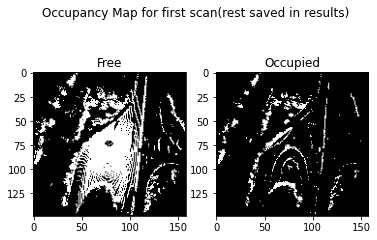

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Occupancy Map for first scan(rest saved in results)')
ax1.imshow(f,cmap='gray')
ax1.set_title('Free')
ax2.imshow(o,cmap='gray')
ax2.set_title('Occupied')

In [23]:
# Part 1

#For all 77 values
for i in range(77):
    f,o = makeMap(use4[i],3)
    plt.imsave('results/free'+str(i)+'.png',f, cmap='gray')
    plt.imsave('results/occ'+str(i)+'.png',o, cmap='gray')

Text(0.5, 1.0, 'Occupied')

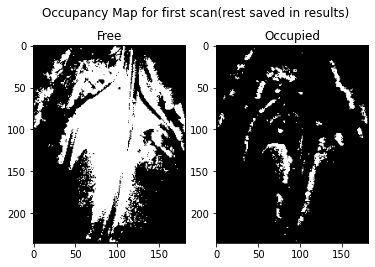

In [24]:
# Part 2

#For registered point cloud
f,o = makeMap(pcd_combined,5)
plt.imsave('results/CombinedFree.png',f, cmap='gray')
plt.imsave('results/CombinedOcc.png',o, cmap='gray')
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Occupancy Map for first scan(rest saved in results)')
ax1.imshow(f,cmap='gray')
ax1.set_title('Free')
ax2.imshow(o,cmap='gray')
ax2.set_title('Occupied')

We see that there is a difference between the two methods in terms of the density. The registered point cloud provides the entire map which is able to produce the entire path way that the car travels. This is clearly evident in the occupied map.